In [ ]:

# Import Libraries
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
# A class that models the Neural Net with L-layers and
# N neurons in each layer. It also contains the functions
# for training, testing, and optimizing the Neural Network

np.random.seed(100)

class DeepNN:

    # Constructor to build the structure of the Neural Network
    # It accepts the layers in the format of [2,3,1] -> 2 Neuron Input Layer,
    # 3 Neuron Hidden Layer and 1 Neuron output layer
    def __init__(self, layers, activations):
        ############################### Initialize the number of layers and neurons
        self.layers = layers
        self.num_layers = len(layers)
        self.hidden_layers = len(layers) - 2
        self.input_neurons = layers[0]
        self.output_neurons = layers[-1]

        ########## Intialize parameters for Forward Propogation
        # Initialize Weights
        self.epsilon = 0.12  # Random Weight Initialization Factor
        self.weights = []
        for i in range(self.num_layers-2):
            self.weights.append(np.random.randn(layers[i]+1, layers[i+1]+1)*2*self.epsilon - self.epsilon)
                        # We add a +1 to incorporate for weights from the +1 neuron for the bias
        self.weights.append(np.random.randn(layers[-2]+1, layers[-1])*2*self.epsilon - self.epsilon)

        self.a = [] # To keep track of activations
        self.z = [] # To keep track of layer values
        self.activations = activations # Activations for each layer

        ######### Intialize parameters for Backward Propogation
        self.delta = []
        self.gradient = []

        # Initialize Scaling
        self.scaler = preprocessing.StandardScaler()

    ################################### Define Some Activation Functions and their derivatives ##################
    def sigmoid(self,x):
        return 1.0/(1.0 + np.exp(-x))

    def sigmoidPrime(self,x):
        return self.sigmoid(x)*(1-self.sigmoid(x))

    def reLU(self,x):
        return np.maximum(x, 0)

    def reLUPrime(self,x):
        return np.where(x > 0, 1.0, 0.0)

    def softmax(self,x):
        return np.exp(x)/np.sum(np.exp(x), axis = 0)

    def tanh(self,x):
        return np.tanh(x)

    def tanh_prime(self,x):
        return 1 - np.power(np.tanh(x),2)

    def identity(self,x):
        return x

    def identity_prime(self,x):
        return 1

    ######################################### Cost Functions #############################################
    # Least Squares
    def least_squares_cost(self,t):
        return 0.5*np.mean( (t-self.a[-1])**2 )

    # Cross Entropy Log Loss Function
    def log_loss(self,t):
        return np.mean( np.nan_to_num( -1*t*np.log(self.a[-1]) - (1-t)*np.log(1-self.a[-1]) ) )

    ######################################### Forward Feed ##############################################
    def forwardFeed(self, X):
        a = [X] # Keep Track of activations
        z = []

        # Add Bias
        c = np.ones([1,a[0].shape[0]]).reshape(a[0].shape[0],1)
        a[0] = np.concatenate((c,a[0]), axis=1)
#         print(a)
        for i in range(self.num_layers-1):
#             print(a[i])
            z.append(np.dot(a[i],self.weights[i]))
            if(self.activations[i] == 'sigmoid'):
                a.append(self.sigmoid(z[i]))
            elif(self.activations[i] == 'reLU'):
                a.append(self.reLU(z[i]))
            elif(self.activations[i] == 'tanh'):
                a.append(self.tanh(z[i]))
            elif(self.activations[i] == 'softmax'):
                a.append(self.softmax(z[i]))
            elif(self.activations[i] == 'identity'):
                a.append(self.identity(z[i]))
        self.a = a
        self.z = z

    def backPropogate(self,y):

        delta = []
        gradient = []
        weights_flipped = self.weights[::-1]
        z_flipped = self.z[::-1]
        activations_flipped = self.a[::-1]
        activation_func_flipped = self.activations[::-1]
        delta.append(activations_flipped[0] - y)
        for i in range(0,self.num_layers-2):
                if(activation_func_flipped[i] == 'sigmoid'):
                    delta.append( np.dot(delta[i], weights_flipped[i].T ) * self.sigmoidPrime(z_flipped[i+1]) )
                elif(activation_func_flipped[i] == 'reLU'):
                    delta.append( np.dot(delta[i], weights_flipped[i].T ) * self.reLUPrime(z_flipped[i+1]) )
                elif(activation_func_flipped[i] == 'tanh'):
                    delta.append( np.dot(delta[i], weights_flipped[i].T ) * self.tanh_prime(z_flipped[i+1]) )
                elif(activation_func_flipped[i] == 'identity'):
                    delta.append( np.dot(delta[i], weights_flipped[i].T ) * self.identity_prime(z_flipped[i+1]) )
                elif(activation_func_flipped[i] == 'softmax'):
                    delta.append( np.dot(delta[i], weights_flipped[i].T))

        delta = delta[::-1]

        for i in range(len(delta)):
            gradient.append( np.dot(self.a[i].T, delta[i]) )
            
        self.delta = delta
        self.gradient = gradient

    def learn(self, epochs, learning_rate, X, y, cost_func, metrics_at=10, optimizer = '', batch_size=10, scaler_type='standard_scaler', split=False, test_size=0.25, beta = 0.9, beta_2 = 0.99, epsilon=10e-8):
        start = time.time()
        
        cost=[]
        
        v_n = []
        s_n = []
        for j in range(len(self.weights)):
            v_n.append(np.zeros(self.weights[j].shape))
            s_n.append(np.zeros(self.weights[j].shape))
            
        if scaler_type == 'min_max_scaler':
            self.scaler = preprocessing.MinMaxScaler()
        X = self.scaler.fit_transform(X)

        if split:
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=0)
            X = X_train
            y = y_train

        
        for i in range(epochs):
                if optimizer == 'mini_batch':
                    # Batch size of 1 makes it SGD
                    no_of_batches = int(len(X)/batch_size)
                    for k in range(no_of_batches):
                        if k==no_of_batches-1:
                            X_sgd = X[k*batch_size:]
                            y_sgd = y[k*batch_size:]
                        else:
                            X_sgd = X[k*batch_size:(k+1)*batch_size]
                            y_sgd = y[k*batch_size:(k+1)*batch_size]
                        self.forwardFeed(X_sgd)
                        self.backPropogate(y_sgd)
                        for j in range(len(self.gradient)):
                            v_n[j] = beta * v_n[j] + (1-beta) * self.gradient[j]
                            self.weights[j] = self.weights[j] - learning_rate * v_n[j]
                elif optimizer == 'rmsprop':
                    # Batch size of 1 makes it SGD
                    no_of_batches = int(len(X)/batch_size)
                    for k in range(no_of_batches):
                        if k==no_of_batches-1:
                            X_sgd = X[k*batch_size:]
                            y_sgd = y[k*batch_size:]
                        else:
                            X_sgd = X[k*batch_size:(k+1)*batch_size]
                            y_sgd = y[k*batch_size:(k+1)*batch_size]
                            
                        self.forwardFeed(X_sgd)
                        self.backPropogate(y_sgd)
                        for j in range(len(self.gradient)):
                            s_n[j] = beta_2 * s_n[j] + (1-beta_2) * np.power(self.gradient[j],2)
                            self.weights[j] = self.weights[j] - learning_rate * self.gradient[j]/np.sqrt(s_n[j]+epsilon)
                elif optimizer == 'adam':
                    # Batch size of 1 makes it SGD
                    no_of_batches = int(len(X)/batch_size)
                    for k in range(no_of_batches):
                        if k==no_of_batches-1:
                            X_sgd = X[k*batch_size:]
                            y_sgd = y[k*batch_size:]
                        else:
                            X_sgd = X[k*batch_size:(k+1)*batch_size]
                            y_sgd = y[k*batch_size:(k+1)*batch_size]
                        self.forwardFeed(X_sgd)
                        self.backPropogate(y_sgd)
                        for j in range(len(self.gradient)):
                            v_n[j] = beta * v_n[j] + (1-beta) * self.gradient[j]
                            s_n[j] = beta_2 * s_n[j] + (1-beta_2) * np.power(self.gradient[j],2)
                            
                            # Beta Correction
                            v_n[j] = v_n[j] / (1-np.power(beta,k)+epsilon)
                            s_n[j] = s_n[j] / (1-np.power(beta_2,k)+epsilon)
                            
                            self.weights[j] = self.weights[j] - learning_rate * v_n[j]/np.sqrt(s_n[j]+epsilon)

                else:
                    self.forwardFeed(X)
                    self.backPropogate(y)
                    for j in range(len(self.gradient)):
                        self.weights[j] = self.weights[j] - learning_rate * self.gradient[j]

                if(i%metrics_at == 0):
                    self.forwardFeed(X)
                    print('Effective epoch: ', i/metrics_at + 1)
                    if(cost_func == 'log_loss'):
                        cost.append(self.log_loss(y))
                        print('Accuracy: ', np.mean(np.round(self.think(X))==y) * 100, '%')
                    elif(cost_func == 'least_squares'):
                        cost.append(self.least_squares_cost(y))
                    print('Cost: ', cost[-1], '\n')

        

        end = time.time()
        
        
        if(cost_func == 'log_loss' and split):
            print('Testing Accuracy: ', np.mean(np.round(self.think(X_test))==y_test) * 100, '%')
        plt.plot(cost)
        print('Time Taken: ', end-start, ' seconds')
        return self.weights

    def think(self,X):
        X = self.scaler.fit_transform(X)
        a = [X] # Keep Track of activations
        z = []

        # Add Bias
        c = np.ones([1,a[0].shape[0]]).reshape(a[0].shape[0],1)
        a[0] = np.concatenate((c,a[0]), axis=1)
#         print(a)
        for i in range(self.num_layers-1):
#             print(a[i])
            z.append(np.dot(a[i],self.weights[i]))
            if(self.activations[i] == 'sigmoid'):
                a.append(self.sigmoid(z[i]))
            elif(self.activations[i] == 'reLU'):
                a.append(self.reLU(z[i]))
            elif(self.activations[i] == 'tanh'):
                a.append(self.tanh(z[i]))
            elif(self.activations[i] == 'softmax'):
                a.append(self.softmax(z[i]))
            elif(self.activations[i] == 'identity'):
                a.append(self.identity(z[i]))
                
        return a[-1]


Effective epoch:  1.0
Cost:  0.32030923486728846 

Effective epoch:  2.0
Cost:  0.25189723773998735 

Effective epoch:  3.0
Cost:  0.25195923493596534 

Effective epoch:  4.0
Cost:  0.25175617493632113 

Effective epoch:  5.0
Cost:  0.2516553180614343 

Effective epoch:  6.0
Cost:  0.25156803271825917 

Effective epoch:  7.0
Cost:  0.25150097417619444 

Effective epoch:  8.0
Cost:  0.2515053337545374 

Effective epoch:  9.0
Cost:  0.25150653297684683 

Effective epoch:  10.0
Cost:  0.25150559218087554 

Time Taken:  4.629393815994263  seconds


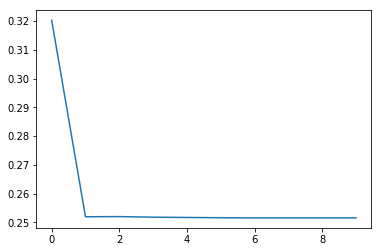

In [159]:
# Part - b Generate Dataset
np.random.seed(100)
X = np.sort(2*np.random.rand(50,1)-1)
t = np.sin(2*(np.pi)*X) + 0.3*np.random.randn(50,1)

# Build NN
NN2 = DeepNN([1,2,1], activations=['reLU','identity'])
w = NN2.learn(epochs=100000, learning_rate=0.001, X=X, y=t, cost_func='least_squares', metrics_at=10000, optimizer='rmsprop',batch_size=32)

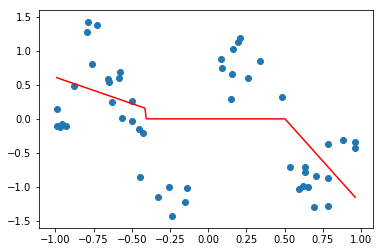

In [160]:
# plot the model
x_mesh = np.linspace(np.min(X),np.max(X),500).reshape(500,1)
y = NN2.think(x_mesh)

plt.plot(x_mesh,y,'r')
# plt.plot(X,t)
plt.scatter(X,t)

Epoch 1/50
50/50 [==============================] - 1s 17ms/step - loss: 0.5634
Epoch 2/50
50/50 [==============================] - 0s 107us/step - loss: 0.5468
Epoch 3/50
50/50 [==============================] - 0s 102us/step - loss: 0.5478
Epoch 4/50
50/50 [==============================] - 0s 91us/step - loss: 0.5446
Epoch 5/50
50/50 [==============================] - 0s 110us/step - loss: 0.5476
Epoch 6/50
50/50 [==============================] - 0s 100us/step - loss: 0.5463
Epoch 7/50
50/50 [==============================] - 0s 100us/step - loss: 0.5428
Epoch 8/50
50/50 [==============================] - 0s 98us/step - loss: 0.5424
Epoch 9/50
50/50 [==============================] - 0s 100us/step - loss: 0.5427
Epoch 10/50
50/50 [==============================] - 0s 98us/step - loss: 0.5456
Epoch 11/50
50/50 [==============================] - 0s 100us/step - loss: 0.5422
Epoch 12/50
50/50 [==============================] - 0s 101us/step - loss: 0.5437
Epoch 13/50
50/50 [==========

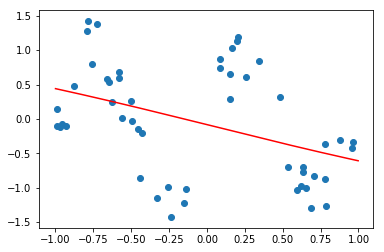

In [155]:
from keras.models import Sequential
from keras.layers import Dense, Activation

model = Sequential([
    Dense(32, input_shape=(1,)),
    Dense(20),
    Activation('tanh'),
#     Dense(20),
#     Activation('relu'),
    Dense(1),
    Activation('linear'),
])

model.compile(optimizer='rmsprop',
              loss='mean_squared_error')

model.fit(X, t, epochs=50, batch_size=32)
model.build()
model.summary()

y = model.predict(x_mesh)
plt.plot(x_mesh,y,'r')
plt.scatter(X,t)

Effective epoch:  1.0
Accuracy:  50.0 %
Cost:  0.6945568523411126 

Effective epoch:  2.0
Accuracy:  50.0 %
Cost:  0.6944829207926017 

Effective epoch:  3.0
Accuracy:  50.0 %
Cost:  0.6944126911963038 

Effective epoch:  4.0
Accuracy:  50.0 %
Cost:  0.6943459389258171 

Effective epoch:  5.0
Accuracy:  50.0 %
Cost:  0.6942824549689004 

Effective epoch:  6.0
Accuracy:  50.0 %
Cost:  0.6942220446811556 

Effective epoch:  7.0
Accuracy:  25.0 %
Cost:  0.6941645266535579 

Effective epoch:  8.0
Accuracy:  25.0 %
Cost:  0.6941097316820924 

Effective epoch:  9.0
Accuracy:  25.0 %
Cost:  0.6940575018290951 

Effective epoch:  10.0
Accuracy:  25.0 %
Cost:  0.6940076895670766 

Effective epoch:  11.0
Accuracy:  25.0 %
Cost:  0.6939601569968374 

Effective epoch:  12.0
Accuracy:  25.0 %
Cost:  0.6939147751325859 

Effective epoch:  13.0
Accuracy:  25.0 %
Cost:  0.6938714232475657 

Effective epoch:  14.0
Accuracy:  25.0 %
Cost:  0.6938299882744039 

Effective epoch:  15.0
Accuracy:  25.0 %
Co

Cost:  0.6921463795547456 

Effective epoch:  237.0
Accuracy:  50.0 %
Cost:  0.692142567130765 

Effective epoch:  238.0
Accuracy:  50.0 %
Cost:  0.6921387479815152 

Effective epoch:  239.0
Accuracy:  50.0 %
Cost:  0.6921349219554795 

Effective epoch:  240.0
Accuracy:  50.0 %
Cost:  0.69213108890121 

Effective epoch:  241.0
Accuracy:  50.0 %
Cost:  0.6921272486673085 

Effective epoch:  242.0
Accuracy:  50.0 %
Cost:  0.6921234011024082 

Effective epoch:  243.0
Accuracy:  50.0 %
Cost:  0.6921195460551562 

Effective epoch:  244.0
Accuracy:  50.0 %
Cost:  0.6921156833741946 

Effective epoch:  245.0
Accuracy:  50.0 %
Cost:  0.6921118129081438 

Effective epoch:  246.0
Accuracy:  50.0 %
Cost:  0.6921079345055849 

Effective epoch:  247.0
Accuracy:  50.0 %
Cost:  0.6921040480150432 

Effective epoch:  248.0
Accuracy:  50.0 %
Cost:  0.69210015328497 

Effective epoch:  249.0
Accuracy:  50.0 %
Cost:  0.6920962501637279 

Effective epoch:  250.0
Accuracy:  50.0 %
Cost:  0.6920923384995727

Effective epoch:  445.0
Accuracy:  50.0 %
Cost:  0.6909358605914351 

Effective epoch:  446.0
Accuracy:  50.0 %
Cost:  0.6909263457654626 

Effective epoch:  447.0
Accuracy:  50.0 %
Cost:  0.690916772216329 

Effective epoch:  448.0
Accuracy:  50.0 %
Cost:  0.6909071394649233 

Effective epoch:  449.0
Accuracy:  50.0 %
Cost:  0.6908974470278773 

Effective epoch:  450.0
Accuracy:  50.0 %
Cost:  0.6908876944175122 

Effective epoch:  451.0
Accuracy:  50.0 %
Cost:  0.6908778811417883 

Effective epoch:  452.0
Accuracy:  50.0 %
Cost:  0.6908680067042505 

Effective epoch:  453.0
Accuracy:  50.0 %
Cost:  0.6908580706039765 

Effective epoch:  454.0
Accuracy:  50.0 %
Cost:  0.69084807233552 

Effective epoch:  455.0
Accuracy:  50.0 %
Cost:  0.6908380113888573 

Effective epoch:  456.0
Accuracy:  50.0 %
Cost:  0.6908278872493303 

Effective epoch:  457.0
Accuracy:  50.0 %
Cost:  0.6908176993975902 

Effective epoch:  458.0
Accuracy:  50.0 %
Cost:  0.6908074473095392 

Effective epoch:  459.0

Effective epoch:  664.0
Accuracy:  75.0 %
Cost:  0.6858148892491744 

Effective epoch:  665.0
Accuracy:  75.0 %
Cost:  0.6857622837440268 

Effective epoch:  666.0
Accuracy:  75.0 %
Cost:  0.6857091329134044 

Effective epoch:  667.0
Accuracy:  75.0 %
Cost:  0.6856554291965269 

Effective epoch:  668.0
Accuracy:  75.0 %
Cost:  0.6856011649006171 

Effective epoch:  669.0
Accuracy:  75.0 %
Cost:  0.6855463321981666 

Effective epoch:  670.0
Accuracy:  75.0 %
Cost:  0.685490923124134 

Effective epoch:  671.0
Accuracy:  75.0 %
Cost:  0.6854349295730781 

Effective epoch:  672.0
Accuracy:  75.0 %
Cost:  0.6853783432962227 

Effective epoch:  673.0
Accuracy:  75.0 %
Cost:  0.68532115589845 

Effective epoch:  674.0
Accuracy:  75.0 %
Cost:  0.685263358835223 

Effective epoch:  675.0
Accuracy:  75.0 %
Cost:  0.685204943409433 

Effective epoch:  676.0
Accuracy:  75.0 %
Cost:  0.6851459007681717 

Effective epoch:  677.0
Accuracy:  75.0 %
Cost:  0.6850862218994245 

Effective epoch:  678.0
A

Accuracy:  75.0 %
Cost:  0.6261019838947766 

Effective epoch:  862.0
Accuracy:  75.0 %
Cost:  0.6248670316065328 

Effective epoch:  863.0
Accuracy:  75.0 %
Cost:  0.6236023801710785 

Effective epoch:  864.0
Accuracy:  75.0 %
Cost:  0.6223072517567776 

Effective epoch:  865.0
Accuracy:  75.0 %
Cost:  0.6209808514805135 

Effective epoch:  866.0
Accuracy:  75.0 %
Cost:  0.6196223674796553 

Effective epoch:  867.0
Accuracy:  75.0 %
Cost:  0.6182309710348365 

Effective epoch:  868.0
Accuracy:  75.0 %
Cost:  0.6168058167483239 

Effective epoch:  869.0
Accuracy:  75.0 %
Cost:  0.615346042783028 

Effective epoch:  870.0
Accuracy:  75.0 %
Cost:  0.6138507711674785 

Effective epoch:  871.0
Accuracy:  75.0 %
Cost:  0.6123191081723585 

Effective epoch:  872.0
Accuracy:  75.0 %
Cost:  0.610750144764457 

Effective epoch:  873.0
Accuracy:  75.0 %
Cost:  0.6091429571441571 

Effective epoch:  874.0
Accuracy:  75.0 %
Cost:  0.60749660737282 

Effective epoch:  875.0
Accuracy:  75.0 %
Cost: 

Accuracy:  100.0 %
Cost:  0.04894716250371308 

Effective epoch:  1101.0
Accuracy:  100.0 %
Cost:  0.048568037864470864 

Effective epoch:  1102.0
Accuracy:  100.0 %
Cost:  0.048194198544983226 

Effective epoch:  1103.0
Accuracy:  100.0 %
Cost:  0.04782554466818118 

Effective epoch:  1104.0
Accuracy:  100.0 %
Cost:  0.0474619786423382 

Effective epoch:  1105.0
Accuracy:  100.0 %
Cost:  0.0471034051020431 

Effective epoch:  1106.0
Accuracy:  100.0 %
Cost:  0.04674973085079028 

Effective epoch:  1107.0
Accuracy:  100.0 %
Cost:  0.04640086480514233 

Effective epoch:  1108.0
Accuracy:  100.0 %
Cost:  0.046056717940423875 

Effective epoch:  1109.0
Accuracy:  100.0 %
Cost:  0.04571720323790617 

Effective epoch:  1110.0
Accuracy:  100.0 %
Cost:  0.04538223563344087 

Effective epoch:  1111.0
Accuracy:  100.0 %
Cost:  0.04505173196750371 

Effective epoch:  1112.0
Accuracy:  100.0 %
Cost:  0.044725610936610684 

Effective epoch:  1113.0
Accuracy:  100.0 %
Cost:  0.04440379304606853 

E


Effective epoch:  1299.0
Accuracy:  100.0 %
Cost:  0.01847928941384033 

Effective epoch:  1300.0
Accuracy:  100.0 %
Cost:  0.018420682993164107 

Effective epoch:  1301.0
Accuracy:  100.0 %
Cost:  0.018362448801938436 

Effective epoch:  1302.0
Accuracy:  100.0 %
Cost:  0.01830458337859013 

Effective epoch:  1303.0
Accuracy:  100.0 %
Cost:  0.018247083303380172 

Effective epoch:  1304.0
Accuracy:  100.0 %
Cost:  0.018189945197787293 

Effective epoch:  1305.0
Accuracy:  100.0 %
Cost:  0.01813316572390135 

Effective epoch:  1306.0
Accuracy:  100.0 %
Cost:  0.01807674158382806 

Effective epoch:  1307.0
Accuracy:  100.0 %
Cost:  0.01802066951910332 

Effective epoch:  1308.0
Accuracy:  100.0 %
Cost:  0.01796494631011816 

Effective epoch:  1309.0
Accuracy:  100.0 %
Cost:  0.017909568775552664 

Effective epoch:  1310.0
Accuracy:  100.0 %
Cost:  0.017854533771820745 

Effective epoch:  1311.0
Accuracy:  100.0 %
Cost:  0.01779983819252306 

Effective epoch:  1312.0
Accuracy:  100.0 %


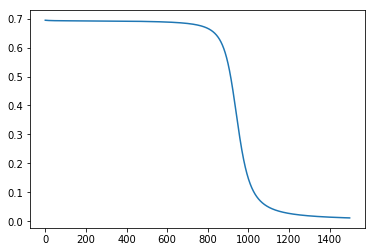

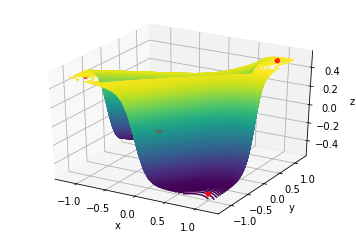

In [6]:


########################## Part a) - Generate Dataset
X = np.array([[-1, -1],[1, 1],[-1, 1],[1, -1]],dtype='float')
t = np.array([1, 1, 0, 0],dtype='float').reshape(4,1)


NN = DeepNN([2,2,1], activations=['tanh','sigmoid'])

w = NN.learn(epochs=1500, learning_rate=0.1, X=X, y=t, cost_func='log_loss', metrics_at=1, split=False)
print('Accuracy: ',np.mean(np.round(NN.think(X))==t) * 100)


x_mesh = np.linspace(-1.2,1.2,30).reshape(30,1)
y_mesh = np.linspace(-1.2,1.2,30).reshape(30,1)

X_mesh, Y_mesh = np.meshgrid(x_mesh,x_mesh)
X_test = np.hstack((x_mesh,y_mesh))



# Classify Points for Decision Boundary
predicitions = np.zeros([len(x_mesh),len(y_mesh)])
for i in range(len(X_mesh)):
    for j in range(len(Y_mesh)):
        pnt = np.array([X_mesh[i,j],Y_mesh[i,j]]).reshape(1,2)
        predicitions[i,j] = NN.think(pnt)[0,0]



import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X_mesh, Y_mesh, predicitions-0.5,1000)

x_xor = [-1, 1, -1, 1]
y_xor = [-1, 1, 1, -1]
t_xor = [0.5, 0.5, -0.5, -0.5]
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.scatter(x_xor, y_xor, t_xor, c='r')
plt.show()